### **Download and import the necessary libraries**

In [213]:
!pip install columnize

In [214]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
from IPython.display import display               # For displaying outputs in the notebook
import matplotlib.pyplot as plt                   #for interactive plots and simple cases of programmatic plot generation
%matplotlib inline                                
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        #provides access to some variables used or maintained by the interpreter
import os                                         # For manipulating filepath names
import time                                       #provides various time-related functions
import warnings                                   #allows you to handle all warnings with the standard logging
import io                                         #interface to access files and streams
warnings.filterwarnings(action = 'ignore')        #warnings filter controls whether warnings are ignored, displayed
from sklearn.model_selection import train_test_split #Quick utility to split data into train and test set
import gensim                                     #topic modelling library for Python that provides access to Word2Vec
import columnize                                  #format a simple (i.e. not nested) list into aligned columns.
from gensim.models import Word2Vec                #topic modelling library for Python that provides access to Word2Vec
from sklearn.manifold import TSNE                 #containing T-SNE algorithms used to project high dimensional space into lower dimesional space
from numpy.linalg import inv                      #Compute the dot product of two or more arrays in a single function call
import scipy.stats                                #contains a large number of probability distributions for statistical analysis
import scipy as sp                                #collection of mathematical algorithms
import seaborn as sns                             #data visualization library based on matplotlib
# import mxnet as mx                                #open-source deep learning software framework, used to train, and deploy deep neural networks.

### **Data**

> The dataset we'll be using in this example was downloaded from following link. https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Inpatient_Claims.html

The data set is the public available Basic Stand Alone (BSA) Inpatient Public Use Files (PUF) named “CMS 2008 BSA Inpatient Claims PUF”. The file contains Medicare inpatient claims from 2008. Each record is an inpatient claim incurred by a 5% sample of Medicare beneficiaries. The file contains seven (7) variables: A primary claim key indexing the records and six (6) analytic variables. One of the analytic variables, claim cost, is provided in two forms, (a) as an integer category and (b) as a dollar average. There are some demographic and claim-related variables provided in this PUF.

However, as beneficiary identities are not provided, it is not possible to link claims that belong to the same beneficiary in the CMS 2008 BSA Inpatient Claims PUF. Without linking beneficiary Id to the claims, it is not possible to create features such as 'amount reimbursed over time', 'average reimbursement per visit' etc.



### Obtain Data



> 
We will use the following link to download claims dataset.

https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip

The data dictionary required to interpret codes in dataset have been constructed from following pdf document.

https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF_DataDic_CB.pdf

Following dictionary files are already avaliable in data folder in the notebook.


*   ColumnNames.csv - column description

*   DiagnosisRelatedGroupNames.csv - dictionary for procedure codes

*   InternationalClassificationOfDiseasesNames.csv - dictionary of diagnosis codes
*   LengthOfStayDays.csv - dictionary of length of stay


*   AgeGroup.csv - dictionary of age group


*   Gender.csv - dictionary of gender








### **Download claims data file from CMS site**

In [215]:
!wget https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip
!unzip -o /content/2008_BSA_Inpatient_Claims_PUF.zip

--2022-02-23 15:32:40--  https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/BSAPUFS/Downloads/2008_BSA_Inpatient_Claims_PUF.zip
Resolving www.cms.gov (www.cms.gov)... 23.65.227.76, 2600:1407:3c00:999::28a, 2600:1407:3c00:989::28a
Connecting to www.cms.gov (www.cms.gov)|23.65.227.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8848030 (8.4M) [application/zip]
Saving to: ‘2008_BSA_Inpatient_Claims_PUF.zip.2’

2008_BSA_Inpatient_ 100%[===================>]   8.44M  --.-KB/s    in 0.1s    

2022-02-23 15:32:40 (72.6 MB/s) - ‘2008_BSA_Inpatient_Claims_PUF.zip.2’ saved [8848030/8848030]

Archive:  /content/2008_BSA_Inpatient_Claims_PUF.zip
  inflating: 2008_BSA_Inpatient_Claims_PUF.csv  


### **Feature Engineering**

In [216]:
# read the ColumnNames csv file to identify meaningful names for column labels in the claim data
colnames = pd.read_csv("/content/drive/MyDrive/data/ColumnNames.csv")
colnames[colnames.columns[-1]] = colnames[colnames.columns[-1]].map(lambda x: x.replace('"','').strip())
display(colnames)

,Column Label,"""Column Name"""
0,IP_CLM_ID,Encrypted PUF ID
1,BENE_SEX_IDENT_CD,Beneficiary gender code
2,BENE_AGE_CAT_CD,Beneficiary Age category code
3,IP_CLM_BASE_DRG_CD,Base DRG code
4,IP_CLM_ICD9_PRCDR_CD,ICD9 primary procedure code
5,IP_CLM_DAYS_CD,Inpatient days code
6,IP_DRG_QUINT_PMT_AVG,DRG quintile average payment amount
7,IP_DRG_QUINT_PMT_CD,DRG quintile payment amount code


In [217]:
# read claims data file
df_cms_claims_data = pd.read_csv('/content/2008_BSA_Inpatient_Claims_PUF.csv')
df_cms_claims_data.columns = colnames[colnames.columns[-1]].ravel()
pd.set_option('display.max_columns', 500)

# print the shape of the data file
print('Shape:', df_cms_claims_data.shape)

# show the top few rows
display(df_cms_claims_data.head())

# describe the data object
display(df_cms_claims_data.describe())

# check the datatype for each column
display(df_cms_claims_data.dtypes)

# check null value for each column
display(df_cms_claims_data.isnull().mean())


Shape: (588415, 8)


,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
0,IP-000022CE4125DBE7,2,4,3,31.0,4,86240,4
1,IP-0000417F50942D90,2,5,199,NaN,2,3447,2
2,IP-0000865F5457AC0E,1,1,119,54.0,4,34878,5
3,IP-00009789630AF474,2,2,128,NaN,2,3007,2
4,IP-0000C9D229B79D36,2,2,236,70.0,1,3352,2


,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code
count,588415.000000,588415.000000,588415.000000,311869.000000,588415.000000,588415.000000,588415.000000
mean,1.561165,3.574610,140.202393,59.683832,2.516377,9312.621422,2.999444
std,0.496245,1.805788,79.686699,29.207527,0.972758,10482.707298,1.414880
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,1.000000,2.000000,82.000000,38.000000,2.000000,4008.000000,2.000000
50%,2.000000,4.000000,123.000000,54.000000,2.000000,6352.000000,3.000000
75%,2.000000,5.000000,200.000000,86.000000,3.000000,10760.000000,4.000000
max,2.000000,6.000000,311.000000,99.000000,4.000000,329467.000000,5.000000


Encrypted PUF ID                        object
Beneficiary gender code                  int64
Beneficiary Age category code            int64
Base DRG code                            int64
ICD9 primary procedure code            float64
Inpatient days code                      int64
DRG quintile average payment amount      int64
DRG quintile payment amount code         int64
dtype: object

Encrypted PUF ID                       0.000000
Beneficiary gender code                0.000000
Beneficiary Age category code          0.000000
Base DRG code                          0.000000
ICD9 primary procedure code            0.469985
Inpatient days code                    0.000000
DRG quintile average payment amount    0.000000
DRG quintile payment amount code       0.000000
dtype: float64

### **Missing values**

In [218]:
#Fill NaN with -1 for "No Procedure Performed"
procedue_na = -1
df_cms_claims_data['ICD9 primary procedure code'].fillna(procedue_na, inplace = True)

#convert procedure code from float to int64
df_cms_claims_data['ICD9 primary procedure code'] = df_cms_claims_data['ICD9 primary procedure code'].astype(np.int64)


#check count of null values to ensure dataframe is updated
display(df_cms_claims_data.isnull().mean())

Encrypted PUF ID                       0.0
Beneficiary gender code                0.0
Beneficiary Age category code          0.0
Base DRG code                          0.0
ICD9 primary procedure code            0.0
Inpatient days code                    0.0
DRG quintile average payment amount    0.0
DRG quintile payment amount code       0.0
dtype: float64

### **Categorical features**


> Munging categorical data is another essential process during data preprocessing. It is necessary to convert categorical features to a numerical representation.

### a. Gender
Since gender is already binary and coded as 1 for Male and 2 for Female, no pre-processing is required.



,bene_sex_ident_cd,Beneficiary gender
0,1,Male
1,2,Female


Text(0, 0.5, 'Percentage claims')

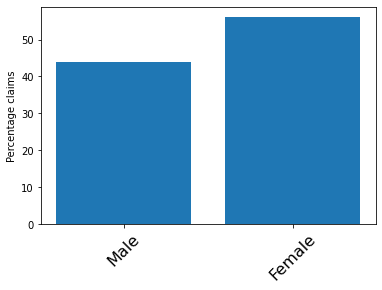

In [219]:
# read gender dictionary csv file
dict_gender = pd.read_csv("/content/drive/MyDrive/data/Gender.csv")
dict_gender.columns = dict_gender.columns.to_series().apply(lambda x: x.strip())
display(dict_gender)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_gender_counts = dict_gender.set_index('bene_sex_ident_cd').join( df_cms_claims_data['Beneficiary gender code'].value_counts() )
tmp_gender_counts['percentage'] = tmp_gender_counts['Beneficiary gender code']/tmp_gender_counts['Beneficiary gender code'].sum()*100

# project gender distribution in the dataset on the bar graph
plt.bar(tmp_gender_counts.index, tmp_gender_counts['percentage'].tolist());
plt.xticks(tmp_gender_counts.index, tmp_gender_counts['Beneficiary gender'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

### b. Age Group


> You may have observed a slight imbalance in claims distribution for male and female records in above bar graph.
Nothing concerning hear. But, we may use this information later in result analysis to justify our anomaly hypothesis.





,BENE_AGE_CAT_CD,Age Group
0,1,Under_65
1,2,65_to_69
2,3,70_to_74
3,4,75_to_79
4,5,80_to_84
5,6,85_and_Older


Text(0, 0.5, 'Percentage claims')

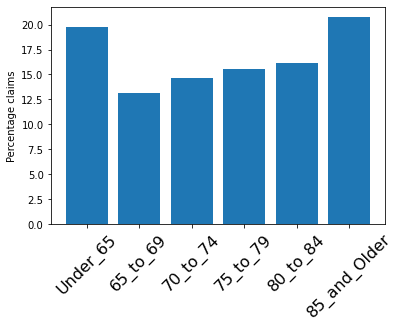

In [220]:
#read AgeGroup csv file into a pandas dataframe
dict_age_group = pd.read_csv("/content/drive/MyDrive/data/AgeGroup.csv", sep=',')
dict_age_group.columns = dict_age_group.columns.to_series().apply(lambda x: x.strip())
display(dict_age_group)

# join the beneficiary category code with age group definition and describe the distribution amongst different age group in claims dataset
tmp_age_sorted_counts = dict_age_group.set_index('BENE_AGE_CAT_CD').join( df_cms_claims_data['Beneficiary Age category code'].value_counts() )
tmp_age_sorted_counts['percentage'] = tmp_age_sorted_counts['Beneficiary Age category code']/tmp_age_sorted_counts['Beneficiary Age category code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.bar(tmp_age_sorted_counts.index, tmp_age_sorted_counts['percentage'].tolist());
plt.xticks(tmp_age_sorted_counts.index, tmp_age_sorted_counts['Age Group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

### **4B. NLP for Textual features**

> 
All physician and hospital claims include one or more diagnosis codes. The ICD-9-CM diagnosis coding system is used since October, 2012.

Hospital inpatient claims also include one or more procedure codes that represent the services performed. The ICD-9-CM diagnosis coding system is used since October, 2012.

The codes are numeric number representing the phrases describing the diagnosis and the procedures itself. The code iteself is numberic but doesn't capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

For diagnosis and procedure codes there is a option to consider it as categorical code and apply one hot encoding to it. That categorical data is defined as variables with a finite set of label values. We apply a technique called one hot encoding to do binarization of such values. In one hot encode we create one column for each label value and mark it as 0 or 1 as applicable to sample record. In case of dignosis code and procedure code it will give us a sparse matrix. Again, the code iteself will be numberic but doesn't capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Inorder to capture, capture context of a word in a document, semantic and syntactic similarity, relation with other words, etc. we use a technique called word embedding to convert every word in a phrase into a vector of floating point numbers. We then average the vector for each word in a phrase to derive vector for a phrase. We will use this approach for both diagnosis and procedure descriptions to extract features.

Word2Vec is a specific method to derieve word embeddings. It can be done using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW)

CBOW Model: This method takes the context of each word as the input and tries to predict the word corresponding to the context.

Skip-Gram model: This method uses the target word (whose representation we want to generate) to predict the context and in the process, we produce the representations.

Both model have their own advantages and disadvantages. Skip Gram works well with small amount of data and is found to represent rare words well.

On the other hand, CBOW is faster and has better representations for more frequent words.

In our use case, we will use CBOW model to derieve wordtovec for pharases used to describe procedure and diagnosis code description.



#### Diagnosis Descriptions

,Base DRG code,Diagnosis related group
0,1,Heart transplant or implant of heart assist sy...
1,2,"ECMO or trach w MV 96+ hrs or PDX exc face, mo..."
2,3,"Trach w MV 96+ hrs or PDX exc face, mouth & ne..."
3,4,Liver transplant
4,5,Lung transplant


Base DRG code               int64
Diagnosis related group    object
dtype: object

Text(0, 0.5, 'Percentage claims')

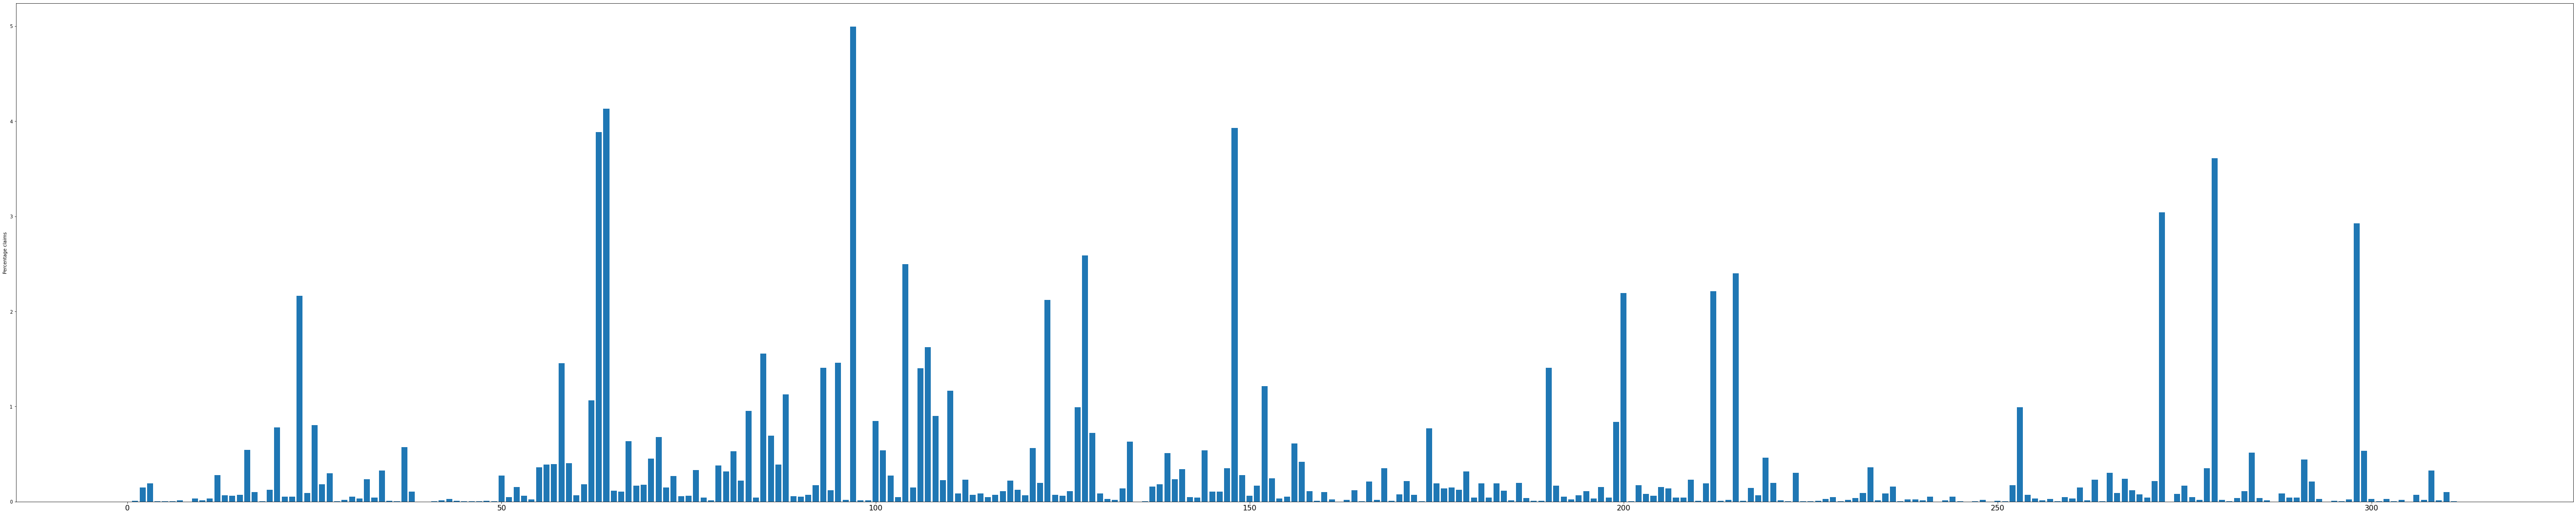

In [221]:
# read the diagnosis names into dataframe, clean up values and display records
dict_diagnosis_names = pd.read_csv('/content/drive/MyDrive/data/DiagnosisRelatedGroupNames.csv', sep=', "', skiprows=1, names=['Base DRG code','Diagnosis related group']);
dict_diagnosis_names['Diagnosis related group'] = dict_diagnosis_names['Diagnosis related group'].map(lambda x: x.replace('"',''));
display(dict_diagnosis_names.head())
display(dict_diagnosis_names.dtypes)


# join the Base DRG code in dictionay with Base DRG code in claims dataframe and describe the distribution amongst different age group in claims dataset
tmp_diagnosis_counts = dict_diagnosis_names.set_index('Base DRG code').join( df_cms_claims_data['Base DRG code'].value_counts() )
tmp_diagnosis_counts['percentage'] = tmp_diagnosis_counts['Base DRG code']/tmp_diagnosis_counts['Base DRG code'].sum()*100

# project age group distribution in the dataset on the bar graph
plt.figure(figsize=(100,20))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_diagnosis_counts.index, tmp_diagnosis_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

#### Observe the distribution of different diagnosis code in above bar graph printed from claims dataset.
Next, let's do text processing on diagnosis descriptions to make some of the acronyms more meaningful for word embeddings

In [222]:
# function to run pre processing on diagnosis descriptions
from nltk.tokenize import sent_tokenize, word_tokenize 

def text_preprocessing(phrase):
    phrase = phrase.lower()
    phrase = phrase.replace('&', 'and')
    #phrase = phrase.replace('non-', 'non') #This is to ensure non-critical, doesn't get handled as {'non', 'critical'}
    phrase = phrase.replace(',','')
    phrase = phrase.replace('w/o','without').replace(' w ',' with ').replace('/',' ')
    phrase = phrase.replace(' maj ',' major ')
    phrase = phrase.replace(' proc ', ' procedure ')
    phrase = phrase.replace('o.r.', 'operating room')
    sentence = phrase.split(' ')
    return sentence

In [223]:
# run pre processing on diagnosis related group
tmp_diagnosis_tokenized = dict_diagnosis_names['Diagnosis related group'].map(lambda x: text_preprocessing(x))
display(tmp_diagnosis_tokenized.head())

0    [heart, transplant, or, implant, of, heart, as...
1    [ecmo, or, trach, with, mv, 96+, hrs, or, pdx,...
2    [trach, with, mv, 96+, hrs, or, pdx, exc, face...
3                                  [liver, transplant]
4                                   [lung, transplant]
Name: Diagnosis related group, dtype: object

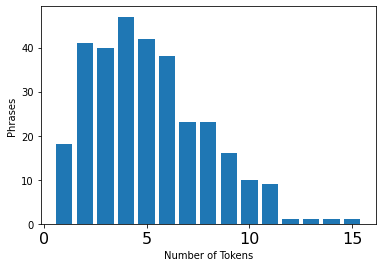

In [224]:

# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
diagnosis_phrase_lengths = tmp_diagnosis_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(diagnosis_phrase_lengths)), diagnosis_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

### Word to vec hyperparameters explained
**size:** The size of the dense vector that is to represent each token or word. If you have very limited data, then size should be a much smaller value. If you have lots of data, its good to experiment with various sizes. A value of 100–150 has worked well for me for similarity lookups.

**window:** The maximum distance between the target word and its neighboring word. If your neighbor’s position is greater than the maximum window width to the left or the right, then some neighbors are not considered as being related to the target word. In theory, a smaller window should give you terms that are more related. If you have lots of data, then the window size should not matter too much, as long as its not overly narrow or overly broad. If you are not too sure about this, just use the default value.

**min_count:** Minimium frequency count of words. The model would ignore words that do not satisfy the min_count.Extremely infrequent words are usually unimportant, so its best to get rid of those. Unless your dataset is really tiny, this does not really affect the model.

**workers:** How many threads to use behind the scenes?

iter: How many epochs to train for? I typically use 10 or more for a small to medium dataset.

In [225]:
# traing wordtovec model on diagnosis description tokens
model_drg = Word2Vec(tmp_diagnosis_tokenized, min_count = 1, size = 72, window = 5, iter = 30)
print(model_drg)
diagnosis_words = list(model_drg.wv.vocab)
print(columnize.columnize(diagnosis_words, displaywidth=80, ljust=False))

Word2Vec(vocab=520, size=72, alpha=0.025)
          heart         pulmonary            combined         evisceration
     transplant          embolism            anterior                  rad
             or       respiratory           posterior         hysterectomy
        implant     inflammations              fusion           vulvectomy
             of           pleural                 fus              uterine
         assist          effusion                cerv               adnexa
         system             edema                curv              ovarian
           ecmo           failure               malig              adnexal
          trach           chronic               infec        uterineadnexa
           with       obstructive                  9+          non-ovarian
             mv           disease            cervical       non-malignancy
            96+            simple           bilateral                dandc
            hrs         pneumonia               joint     

In [226]:
# plot TSNE visualization
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2500, random_state=10)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

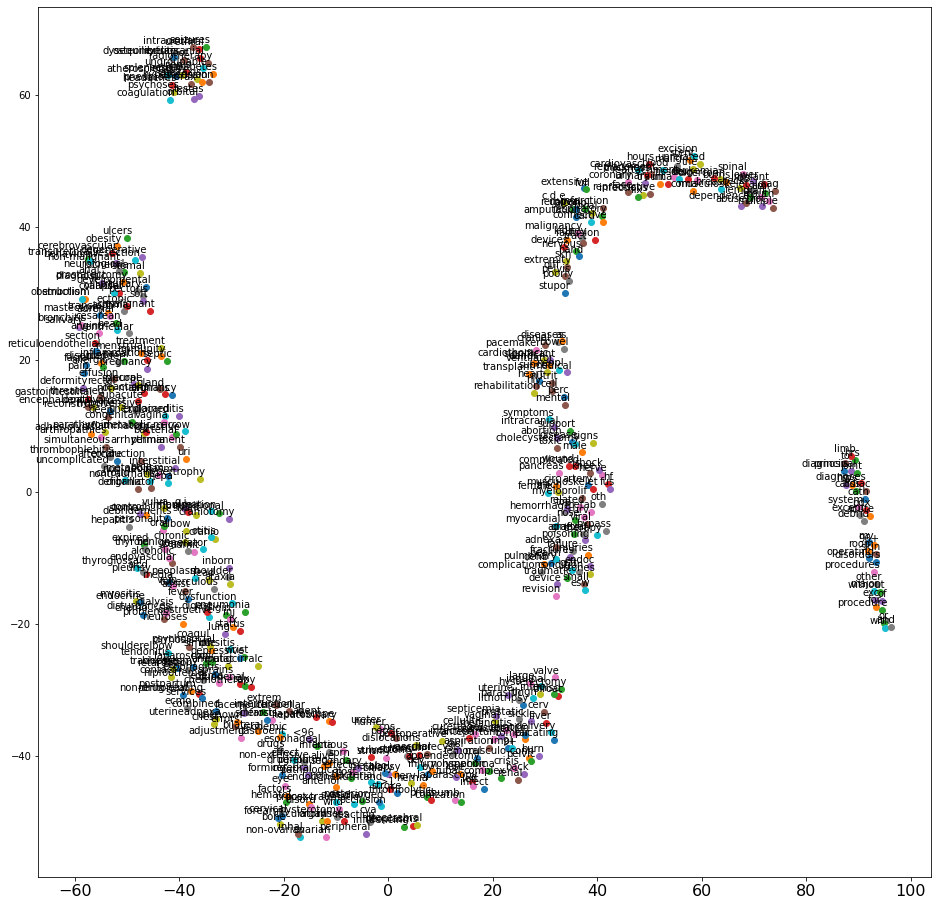

In [227]:
# plot t_SNE chart for diagnosis word to vector. 
#2D visual plot of word embeddings derieved from diagnosis description.
tsne_plot(model_drg)

In [228]:
# test most similiar for some word from model_drg.wv.keywords
model_drg.most_similar('diagnosis')

[('with', 0.9975392818450928),
 ('and', 0.9973859786987305),
 ('room', 0.9971327185630798),
 ('of', 0.996887743473053),
 ('procedure', 0.9968459606170654),
 ('exc', 0.9968244433403015),
 ('operating', 0.9967793822288513),
 ('or', 0.9967575669288635),
 ('major', 0.996566891670227),
 ('96+', 0.9965389370918274)]

In [229]:
# extract diagnosis words that starts with non
#display(tmp_diagnosis_tokenized.head())
series_diagnosis = pd.Series(diagnosis_words)
diagnosis_words_with_non = series_diagnosis[series_diagnosis.map(lambda x: 'non' in x)]
display(diagnosis_words_with_non)

76          nonspecific
89         nontraumatic
99        non-bacterial
183    non-drug-eluting
344       non-malignant
370        non-neoplasm
399         non-ovarian
400      non-malignancy
444           non-acute
507       non-extensive
dtype: object

In [230]:
# Check similarity between diagnosis words with opposite severity
for i in diagnosis_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in diagnosis_words:
        print('Cosine similarity between', a, not_a, ':', model_drg.wv.similarity(a, not_a))
        print('')

Cosine similarity between traumatic nontraumatic : 0.9000833

Cosine similarity between bacterial non-bacterial : 0.868341

Cosine similarity between drug-eluting non-drug-eluting : 0.93093216

Cosine similarity between malignant non-malignant : 0.41865286

Cosine similarity between neoplasm non-neoplasm : 0.8212462

Cosine similarity between ovarian non-ovarian : 0.9393918

Cosine similarity between malignancy non-malignancy : 0.87625796

Cosine similarity between acute non-acute : 0.9845652

Cosine similarity between extensive non-extensive : 0.9664192



In [231]:
# calculate mean of word vector in a phrase to derieve phrase vector for diagnosis description
# we plan to use mean of word vectors to derive word embeddings for a phrase
values = []
index =[]
#iterate through list of strings in each diagnosis phrase
for i, v in pd.Series(tmp_diagnosis_tokenized).items():
    #calculate mean of all word embeddings in each diagnosis phrase
    values.append(model_drg[v].mean(axis =0))
    index.append(i)
tmp_diagnosis_phrase_vector = pd.DataFrame({'Base DRG code':index, 'DRG_VECTOR':values})
display(tmp_diagnosis_phrase_vector.head())

,Base DRG code,DRG_VECTOR
0,0,"[0.048738215, -0.069280684, -0.11781759, -0.04..."
1,1,"[0.073816806, -0.107990496, -0.18206663, -0.06..."
2,2,"[0.07076992, -0.10373032, -0.17573431, -0.0607..."
3,3,"[0.021477489, -0.031293105, -0.043894757, -0.0..."
4,4,"[0.017951556, -0.02327079, -0.03408523, -0.017..."


In [232]:
# expand tmp_diagnosis_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
diagnosis_features = tmp_diagnosis_phrase_vector['DRG_VECTOR'].apply(pd.Series)

# rename each variable in diagnosis_features use DRG_F as prefix
diagnosis_features = diagnosis_features.rename(columns = lambda x : 'DRG_F' + str(x + 1))

# view the diagnosis_features dataframe
display(diagnosis_features.head())

,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72
0,0.048738,-0.069281,-0.117818,-0.043433,0.035847,-0.049998,0.099068,0.038630,-0.034617,0.091730,0.037926,0.076374,-0.037397,0.096587,0.008765,0.002871,-0.027755,-0.008072,0.162332,-0.042017,-0.074143,-0.009377,0.042818,0.001646,-0.041092,-0.035088,0.024312,-0.109103,-0.001052,0.093640,-0.025360,-0.054431,-0.011311,-0.095788,-0.070293,-0.012140,0.026752,-0.046051,-0.059135,0.106226,-0.143958,0.149937,-0.118995,0.103328,-0.043654,0.005585,-0.020991,-0.041808,-0.096767,-0.028694,-0.046748,-0.043285,0.121066,-0.071911,0.086781,0.035779,0.048282,-0.047375,-0.022835,-0.007849,-0.112245,0.039629,-0.027363,-0.077014,-0.007841,-0.008753,-0.106433,0.112596,-0.004888,0.064032,0.047680,-0.062780
1,0.073817,-0.107990,-0.182067,-0.062956,0.058651,-0.075868,0.151684,0.057353,-0.055617,0.133741,0.061695,0.117243,-0.053829,0.146227,0.014461,0.004708,-0.046973,-0.012026,0.245391,-0.061621,-0.114123,-0.009984,0.065719,-0.000202,-0.064212,-0.055177,0.036726,-0.163171,-0.001285,0.141756,-0.034054,-0.083636,-0.019333,-0.139855,-0.109866,-0.020086,0.042696,-0.069734,-0.088013,0.157363,-0.221154,0.227495,-0.181804,0.159563,-0.062288,0.012596,-0.032250,-0.064129,-0.141982,-0.043547,-0.073375,-0.063985,0.186557,-0.104760,0.132063,0.056353,0.071984,-0.070026,-0.032312,-0.016329,-0.169035,0.057337,-0.040151,-0.115837,-0.017496,-0.012294,-0.158649,0.174201,-0.011550,0.096707,0.071913,-0.094252
2,0.070770,-0.103730,-0.175734,-0.060746,0.056739,-0.073278,0.147687,0.055610,-0.053062,0.128869,0.059938,0.113267,-0.051571,0.140303,0.014244,0.003955,-0.044909,-0.011721,0.236611,-0.059037,-0.110203,-0.009981,0.063662,-0.000708,-0.060889,-0.053255,0.035673,-0.156945,-0.000914,0.137285,-0.032605,-0.081715,-0.018834,-0.134538,-0.106142,-0.019374,0.041452,-0.068192,-0.085183,0.151881,-0.213418,0.219530,-0.176508,0.154361,-0.059380,0.012323,-0.030966,-0.061856,-0.136734,-0.042116,-0.070154,-0.062114,0.179005,-0.101159,0.127775,0.054575,0.068578,-0.066813,-0.031392,-0.015974,-0.163171,0.055076,-0.039113,-0.111424,-0.016986,-0.012961,-0.152538,0.168326,-0.011810,0.093256,0.070101,-0.090848
3,0.021477,-0.031293,-0.043895,-0.018237,0.009363,-0.014752,0.044666,0.013961,-0.009968,0.039512,0.019244,0.031596,-0.017777,0.039865,0.004663,0.001639,-0.011118,-0.007968,0.063487,-0.019291,-0.033691,-0.001296,0.018077,-0.002624,-0.015594,-0.010781,0.012916,-0.044275,0.005955,0.036983,-0.015485,-0.018638,-0.001310,-0.037388,-0.029498,-0.006702,0.007293,-0.019007,-0.022260,0.041152,-0.055447,0.058325,-0.051950,0.042368,-0.016555,0.000501,-0.009965,-0.011432,-0.042069,-0.018472,-0.017571,-0.017495,0.049012,-0.026572,0.034444,0.017033,0.018926,-0.025114,-0.012115,-0.003125,-0.048245,0.017359,-0.010428,-0.030905,-0.002571,-0.000768,-0.044628,0.046503,-0.000504,0.028185,0.018050,-0.024268
4,0.017952,-0.023271,-0.034085,-0.017097,0.009471,-0.009757,0.035665,0.012413,-0.011858,0.032401,0.014473,0.030172,-0.010242,0.028481,0.001334,0.003188,-0.007507,-0.003127,0.052920,-0.012394,-0.028281,-0.000543,0.016342,-0.001964,-0.008399,-0.014172,0.007472,-0.034869,0.003822,0.032841,-0.011830,-0.012412,-0.001602,-0.026916,-0.025276,-0.008808,0.004153,-0.018165,-0.017412,0.035554,-0.047032,0.047716,-0.038964,0.031013,-0.017135,0.001370,-0.003392,-0.010290,-0.035791,-0.014842,-0.014287,-0.016753,0.041327,-0.018281,0.027166,0.012247,0.016969,-0.014957,-0.011477,0.000451,-0.036722,0.018774,-0.009068,-0.025343,-0.002437,-0.005032,-0.035498,0.038162

#### Procedure Descriptions

In [233]:
#read procedure code and procedure description mappings
dict_procedure_names = pd.read_csv('/content/drive/MyDrive/data/InternationalClassificationOfDiseasesNames.csv', 
                              sep=', "', 
                              skiprows=1, 
                              names=['ICD9 primary procedure code','International Classification of Diseases'])

#replace double quotes with blank
dict_procedure_names = dict_procedure_names.applymap(lambda x: x.replace('"',''))

# replace -1 as code for 'No procedure performed'. In the dictionary the code is set as blank.
dict_procedure_names.iloc[0]['ICD9 primary procedure code'] = procedue_na

# convert procedure code from float to int64
dict_procedure_names['ICD9 primary procedure code'] = dict_procedure_names['ICD9 primary procedure code'].astype(np.int64)


# check the datatype for each column
display(dict_procedure_names.dtypes)

# display first five records in dictionary
display(dict_procedure_names.head())

ICD9 primary procedure code                  int64
International Classification of Diseases    object
dtype: object

,ICD9 primary procedure code,International Classification of Diseases
0,-1,No procedure performed
1,0,Not elsewhere classified
2,1,Incise-excis brain/skull
3,2,Other skull/brain ops
4,3,Spinal cord & canal ops


In [234]:
display(dict_procedure_names.count())

ICD9 primary procedure code                 101
International Classification of Diseases    101
dtype: int64

Text(0, 0.5, 'Percentage claims')

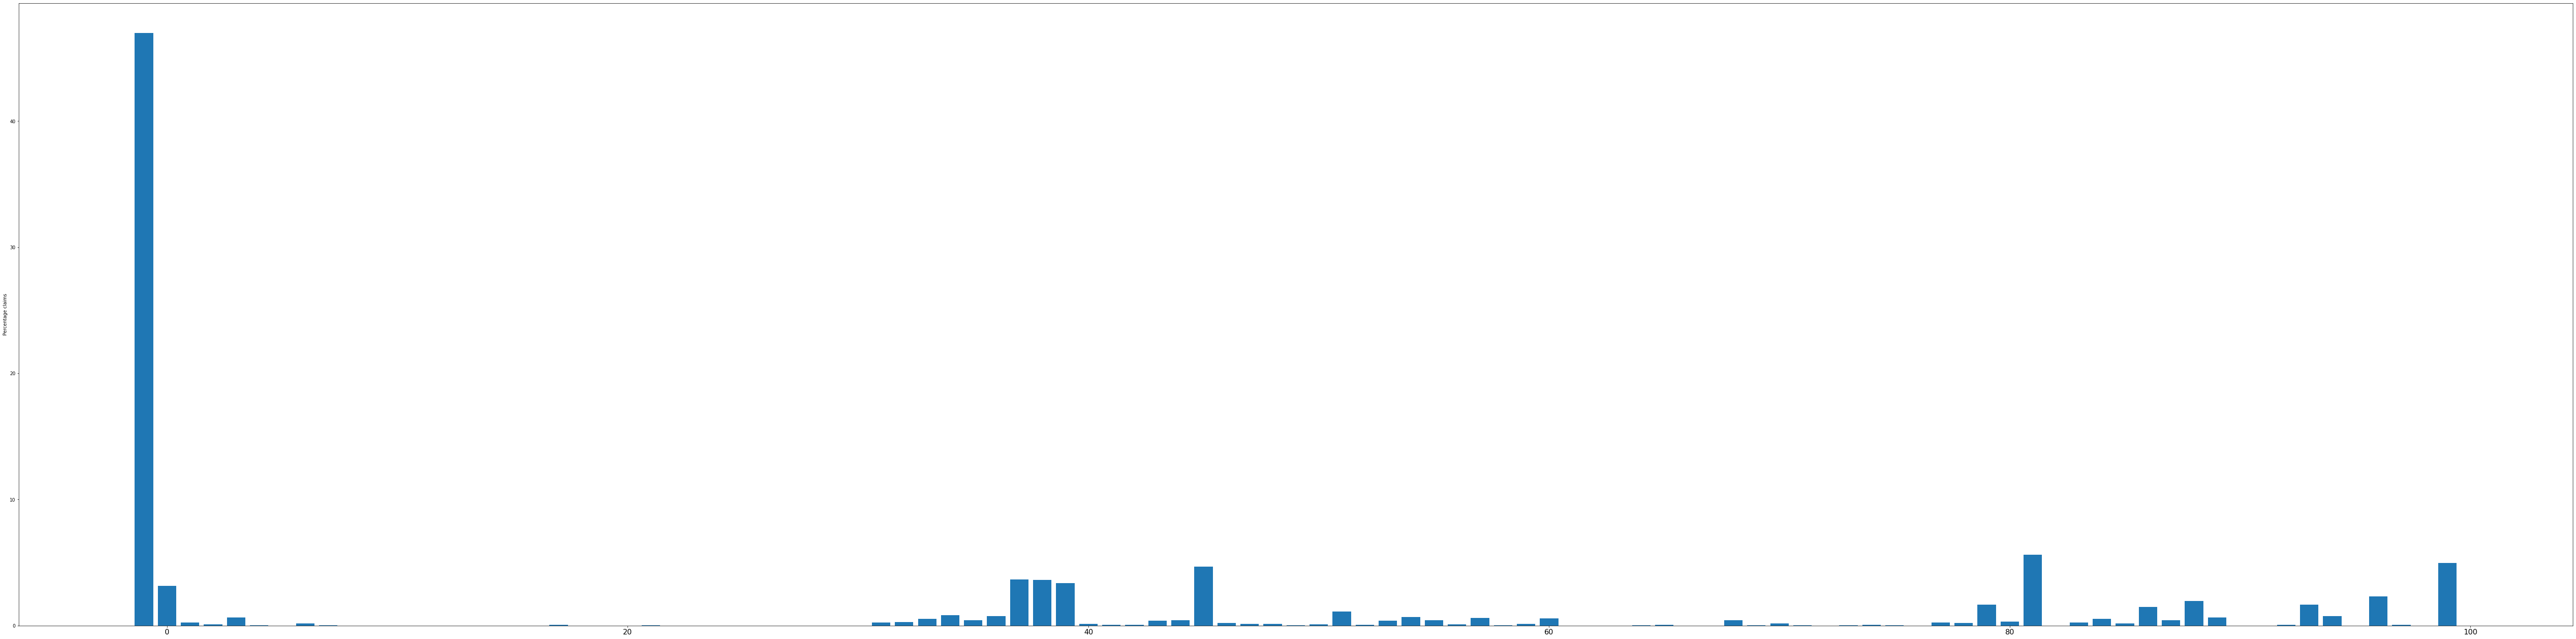

In [235]:
# join the ICD9 primary procedure code in dictionay with ICD9 primary procedure code in claims dataframe and plot the distribution of procedures in the claims dataset
tmp_procedure_counts = dict_procedure_names.set_index('ICD9 primary procedure code').join(df_cms_claims_data['ICD9 primary procedure code'].value_counts() )
tmp_procedure_counts['percentage'] = tmp_procedure_counts['ICD9 primary procedure code']/tmp_procedure_counts['ICD9 primary procedure code'].sum()*100

# project procedure distribution in the claims dataset on the bar graph
plt.figure(figsize=(100,25))
plt.rc('xtick', labelsize=16)
plt.bar(tmp_procedure_counts.index, tmp_procedure_counts['percentage'].tolist());
#plt.xticks(tmp_diagnosis_counts.index, tmp_diagnosis_counts['Diagnosis related group'].tolist(), rotation=45)
plt.ylabel('Percentage claims')

In [236]:
# run pre processing on procedure descriptions
tmp_procedure_tokenized = dict_procedure_names['International Classification of Diseases'].map(lambda x: text_preprocessing(x))
display(tmp_procedure_tokenized.head())

0         [no, procedure, performed]
1       [not, elsewhere, classified]
2       [incise-excis, brain, skull]
3         [other, skull, brain, ops]
4    [spinal, cord, and, canal, ops]
Name: International Classification of Diseases, dtype: object

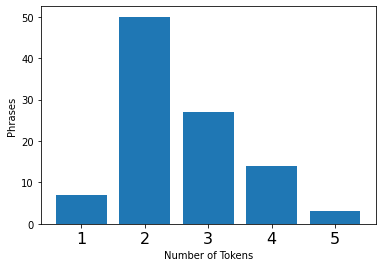

In [237]:
# build a map of number of tokens in a phrase to number of phrases with speific number of phrases
procedure_phrase_lengths = tmp_procedure_tokenized.map(lambda x: len(x)).value_counts().sort_index()

# plot count of tokens in phrase on x-axis and number of phrases with a specific count of tokens in y-axis
plt.bar(np.arange(1,1+len(procedure_phrase_lengths)), procedure_phrase_lengths)
plt.xlabel('Number of Tokens');
plt.ylabel('Phrases');

In [238]:
# traing wordtovec model on procedure description tokens
model_prc = Word2Vec(tmp_procedure_tokenized, min_count = 1, size = 72, window = 5, iter = 100)
print(model_prc)
procedure_words = list(model_prc.wv.vocab)
print(columnize.columnize(procedure_words, displaywidth=80, ljust=False))

Word2Vec(vocab=193, size=72, alpha=0.025)
          no        segment          of      liver     cul-de-sac    diagnostic
   procedure           lens      larynx    biliary         vulvar     radiology
   performed      posterior     trachea      tract       perineal            dx
         not    extraocular         nec   pancreas         forcep     interview
   elsewhere         muscle        lung     repair            vac       consult
  classified          orbit    bronchus     hernia         breech          exam
incise-excis        eyeball   bronchial    abdomen          deliv   microscopic
       brain  miscellaneous      thorax     region         assist       exam--i
       skull     procedures      except     kidney         induce      exam--ii
       other       external       heart     ureter      c-section       nuclear
         ops            ear      valves    urinary          fetus      medicine
      spinal         middle       septa    bladder      obstetric            p

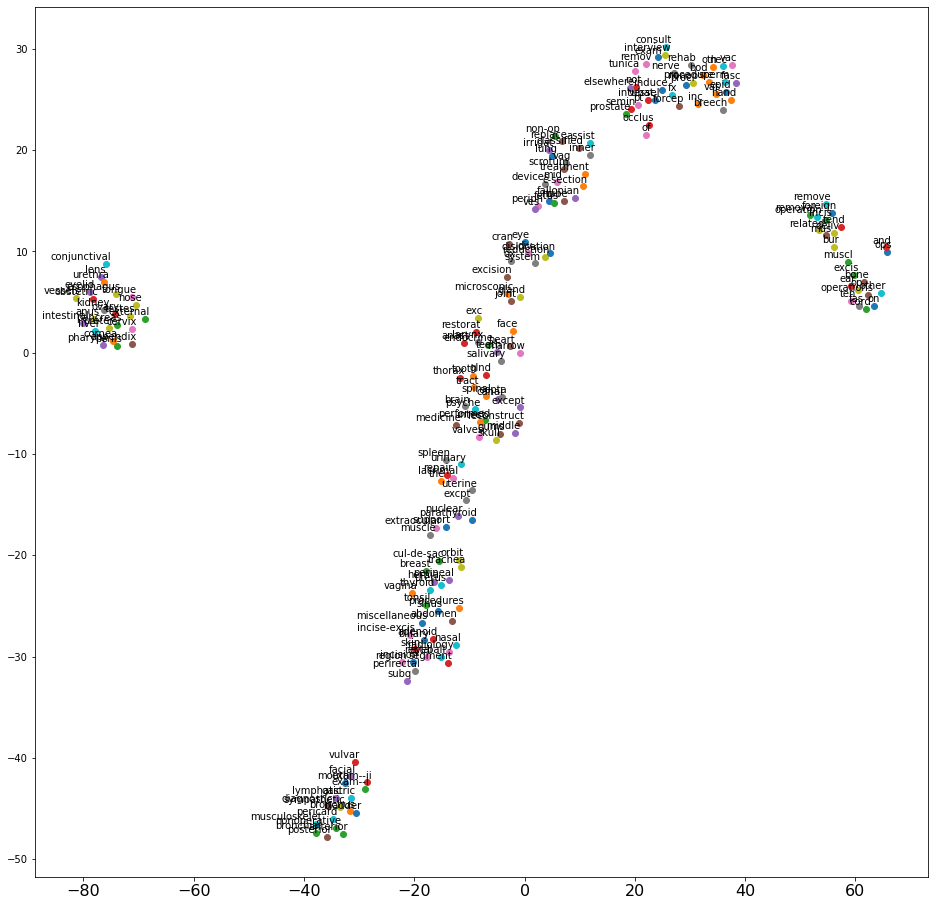

In [239]:
# plot t_SNE chart for procedure word to vector
# #2D visual plot of word embeddings derieved from procedure description.
tsne_plot(model_prc)

In [240]:
# test most similiar for some word from model_prc.wv.keywords
model_prc.most_similar('nonoperative')

[('vas', 0.9367091059684753),
 ('mus', 0.9344817399978638),
 ('scrotum', 0.9324288368225098),
 ('ten', 0.9321110248565674),
 ('devices', 0.9321061372756958),
 ('classified', 0.9315435290336609),
 ('not', 0.9311783313751221),
 ('thorax', 0.9309974908828735),
 ('intubat', 0.9305263757705688),
 ('ops', 0.9303920865058899)]

In [241]:
# extract procedure words that starts with non
#display(tmp_procedure_tokenized.head())
series_procedure = pd.Series(procedure_words)
procedure_words_with_non = series_procedure[series_procedure.map(lambda x: 'non' in x)]
display(procedure_words_with_non)

182          non-op
188           nonop
192    nonoperative
dtype: object

In [242]:
# Check similarity between procedure words with opposite severity
for i in procedure_words_with_non:
    a, not_a = i.replace('non-','').replace('non',''), i
    if a in procedure_words:
        print('Cosine similarity between', a, not_a, ':', model_prc.wv.similarity(a, not_a))
        print('')

Cosine similarity between op non-op : 0.98608744

Cosine similarity between op nonop : 0.9916787



In [243]:
# calculate mean of word vector in a phrase to derieve phrase vector for procedure description 
values = []
index =[]
#iterate through list of strings in each procedure phrase
for i, v in pd.Series(tmp_procedure_tokenized).items():
    #calculate mean of all word embeddings in each procedure phrase
    values.append(model_prc[v].mean(axis =0))
    index.append(i)
tmp_procedure_phrase_vector = pd.DataFrame({'ICD9 primary procedure code':index, 'PRC_VECTOR':values})
display(tmp_procedure_phrase_vector.head())

,ICD9 primary procedure code,PRC_VECTOR
0,0,"[0.043821204, -0.019412545, -0.020399855, -0.0..."
1,1,"[0.04243569, -0.024156692, -0.024573863, -0.02..."
2,2,"[0.027643746, -0.011411113, -0.01584872, -0.01..."
3,3,"[0.0809751, -0.03913769, -0.04571814, -0.04719..."
4,4,"[0.098943606, -0.054172605, -0.053455424, -0.0..."


In [244]:
# expand tmp_procedure_phrase_vector into dataframe
# every scalar value in phrase vector will be considered a feature
procedure_features = tmp_procedure_phrase_vector['PRC_VECTOR'].apply(pd.Series)

# rename each variable in procedure_features use PRC_F as prefix
procedure_features = procedure_features.rename(columns = lambda x : 'PRC_F' + str(x + 1))

# view the procedure_features dataframe
display(procedure_features.head())

,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,0.043821,-0.019413,-0.020400,-0.027538,0.001908,-0.008774,0.031966,0.062446,0.007599,0.020611,0.003544,-0.000546,-0.026217,-0.038624,0.067696,-0.024683,0.005082,0.012886,-0.020978,-0.029931,0.045724,0.006464,0.046971,-0.006151,0.048165,-0.070188,-0.029469,0.021659,-0.021950,0.016860,-0.094606,0.015550,0.000834,-0.004017,-0.031633,-0.005092,0.066435,0.015160,-0.033844,-0.011495,-0.033462,0.048017,-0.047218,0.047704,-0.036932,0.017670,-0.043334,0.049257,-0.016657,-0.044884,-0.008052,-0.013782,0.026242,0.014243,0.006009,-0.013130,-0.010528,0.058475,0.007559,0.002837,0.007193,0.039111,-0.016560,0.000528,0.042327,-0.006708,0.011058,0.005681,-0.044796,0.034842,-0.046664,-0.002454
1,0.042436,-0.024157,-0.024574,-0.029195,0.005229,-0.007663,0.028937,0.071734,0.011821,0.016897,-0.001506,-0.000268,-0.030160,-0.041255,0.065841,-0.015624,0.002792,0.016491,-0.020505,-0.021086,0.048672,0.005974,0.040126,-0.002196,0.061095,-0.073727,-0.032619,0.025676,-0.020558,0.016912,-0.102282,0.016635,0.000096,-0.008535,-0.029682,-0.012407,0.077310,0.018559,-0.033564,-0.011228,-0.031249,0.049871,-0.047553,0.049817,-0.040993,0.021599,-0.042959,0.053161,-0.017496,-0.045588,-0.010964,-0.006648,0.031763,0.013890,-0.000509,-0.018304,-0.017874,0.062498,0.002848,0.007866,0.009079,0.040660,-0.014094,-0.000559,0.039673,-0.009236,0.009185,0.001520,-0.047954,0.035268,-0.045334,-0.004141
2,0.027644,-0.011411,-0.015849,-0.014146,-0.000169,-0.001154,0.020801,0.042303,0.006235,0.011029,0.001974,-0.000372,-0.017200,-0.025680,0.042076,-0.011075,0.005061,0.010743,-0.007664,-0.017973,0.027462,0.006528,0.028814,-0.009789,0.039346,-0.043824,-0.022874,0.023536,-0.018642,0.013995,-0.066430,0.011440,-0.002442,-0.003810,-0.027755,0.002072,0.045650,0.015374,-0.019327,-0.007364,-0.025323,0.028531,-0.025880,0.031301,-0.026208,0.012941,-0.031726,0.032736,-0.013369,-0.030847,-0.002317,-0.010505,0.018096,0.014548,-0.000963,-0.008956,-0.010239,0.044101,0.006178,0.005561,0.005503,0.029837,-0.010347,-0.002633,0.029463,-0.002958,0.000989,0.001232,-0.029922,0.021494,-0.029885,-0.001697
3,0.080975,-0.039138,-0.045718,-0.047192,-0.000586,-0.011034,0.059669,0.122019,0.016795,0.036391,0.004840,0.002359,-0.050238,-0.075277,0.123253,-0.034472,0.009912,0.033037,-0.035833,-0.046895,0.081272,0.013255,0.082722,-0.012107,0.105818,-0.127296,-0.061657,0.050340,-0.049645,0.031380,-0.182359,0.028621,-0.000474,-0.016541,-0.064623,-0.008736,0.129896,0.033183,-0.057352,-0.018361,-0.054944,0.086378,-0.081502,0.081940,-0.072735,0.034633,-0.077844,0.091629,-0.030998,-0.079620,-0.014646,-0.023037,0.047790,0.034011,0.002108,-0.028642,-0.019182,0.119487,0.010939,0.006604,0.020061,0.075592,-0.030989,-0.010276,0.079532,-0.009097,0.014116,-0.001267,-0.080456,0.058927,-0.086968,-0.005836
4,0.098944,-0.054173,-0.053455,-0.056764,0.003063,-0.014087,0.069588,0.149138,0.020157,0.048624,0.003844,0.007733,-0.062408,-0.089276,0.150344,-0.046115,0.010120,0.040533,-0.044745,-0.060674,0.100270,0.018096,0.099301,-0.010999,0.127861,-0.157206,-0.069868,0.055461,-0.064251,0.035689,-0.223790,0.038379,0.001406,-0.019701,-0.078334,-0.016947,0.162701,0.037606,-0.064828,-0.029528,-0.064639,0.107492,-0.098047,0.099992,-0.094019,0.040443,-0.094099,0.109526,-0.039174,-0.098845,-0.017353,-0.032084,0.061516,0.042197,0.002836,-0.034501,-0.022521,0.147406,0.012139,0.007210,0.024531,0.092283,-0.039088,-0.009195,0.089984,-0.015818,0.020710,-0.002726,-0.101984,0.072290,-0.102790,-0.0092

In [245]:
#merge diagnosis word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_diagnosis = pd.merge(df_cms_claims_data, diagnosis_features, how='inner', left_on = 'Base DRG code', right_index = True)
display(tmp_join_claim_diagnosis.head())

#merge procedure word embeddings derived using word2vec in the base claims data as new features.
tmp_join_claim_procedure = pd.merge(tmp_join_claim_diagnosis, procedure_features, how='inner', left_on = 'ICD9 primary procedure code', right_index = True)
display(tmp_join_claim_procedure.head())

#assign new feature set with procedure and diagnosis work embeddings to a new claims feature dataframe
#aggregate all the features extrcated so far to build a final claims feature set for training
claims_features = tmp_join_claim_procedure

,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72
0,IP-000022CE4125DBE7,2,4,3,31,4,86240,4,0.021477,-0.031293,-0.043895,-0.018237,0.009363,-0.014752,0.044666,0.013961,-0.009968,0.039512,0.019244,0.031596,-0.017777,0.039865,0.004663,0.001639,-0.011118,-0.007968,0.063487,-0.019291,-0.033691,-0.001296,0.018077,-0.002624,-0.015594,-0.010781,0.012916,-0.044275,0.005955,0.036983,-0.015485,-0.018638,-0.00131,-0.037388,-0.029498,-0.006702,0.007293,-0.019007,-0.02226,0.041152,-0.055447,0.058325,-0.05195,0.042368,-0.016555,0.000501,-0.009965,-0.011432,-0.042069,-0.018472,-0.017571,-0.017495,0.049012,-0.026572,0.034444,0.017033,0.018926,-0.025114,-0.012115,-0.003125,-0.048245,0.017359,-0.010428,-0.030905,-0.002571,-0.000768,-0.044628,0.046503,-0.000504,0.028185,0.01805,-0.024268
272,IP-001F146D172CA419,1,1,3,31,4,56756,2,0.021477,-0.031293,-0.043895,-0.018237,0.009363,-0.014752,0.044666,0.013961,-0.009968,0.039512,0.019244,0.031596,-0.017777,0.039865,0.004663,0.001639,-0.011118,-0.007968,0.063487,-0.019291,-0.033691,-0.001296,0.018077,-0.002624,-0.015594,-0.010781,0.012916,-0.044275,0.005955,0.036983,-0.015485,-0.018638,-0.00131,-0.037388,-0.029498,-0.006702,0.007293,-0.019007,-0.02226,0.041152,-0.055447,0.058325,-0.05195,0.042368,-0.016555,0.000501,-0.009965,-0.011432,-0.042069,-0.018472,-0.017571,-0.017495,0.049012,-0.026572,0.034444,0.017033,0.018926,-0.025114,-0.012115,-0.003125,-0.048245,0.017359,-0.010428,-0.030905,-0.002571,-0.000768,-0.044628,0.046503,-0.000504,0.028185,0.01805,-0.024268
1055,IP-00769E0F26D617F0,1,3,3,31,4,27725,1,0.021477,-0.031293,-0.043895,-0.018237,0.009363,-0.014752,0.044666,0.013961,-0.009968,0.039512,0.019244,0.031596,-0.017777,0.039865,0.004663,0.001639,-0.011118,-0.007968,0.063487,-0.019291,-0.033691,-0.001296,0.018077,-0.002624,-0.015594,-0.010781,0.012916,-0.044275,0.005955,0.036983,-0.015485,-0.018638,-0.00131,-0.037388,-0.029498,-0.006702,0.007293,-0.019007,-0.02226,0.041152,-0.055447,0.058325,-0.05195,0.042368,-0.016555,0.000501,-0.009965,-0.011432,-0.042069,-0.018472,-0.017571,-0.017495,0.049012,-0.026572,0.034444,0.017033,0.018926,-0.025114,-0.012115,-0.003125,-0.048245,0.017359,-0.010428,-0.030905,-0.002571,-0.000768,-0.044628,0.046503,-0.000504,0.028185,0.01805,-0.024268
1385,IP-009C3541718DECF9,2,4,3,31,4,69162,3,0.021477,-0.031293,-0.043895,-0.018237,0.009363,-0.014752,0.044666,0.013961,-0.009968,0.039512,0.019244,0.031596,-0.017777,0.039865,0.004663,0.001639,-0.011118,-0.007968,0.063487,-0.019291,-0.033691,-0.001296,0.018077,-0.002624,-0.015594,-0.010781,0.012916,-0.044275,0.005955,0.036983,-0.015485,-0.018638,-0.00131,-0.037388,-0.029498,-0.006702,0.007293,-0.019007,-0.02226,0.041152,-0.055447,0.058325,-0.05195,0.042368,-0.016555,0.000501,-0.009965,-0.011432,-0.042069,-0.018472,-0.017571,-0.017495,0.049012,-0.026572,0.034444,0.017033,0.018926,-0.025114,-0.012115,-0.003125,-0.048245,0.017359,-0.010428,-0.030905,-0.002571,-0.000768,-0.044628,0.046503,-0.000504,0.028185,0.01805,-0.024268
1474,IP-00A71BB8A6B8548E,1,5,3,31,4,86240,4,0.021477,-0.031293,-0.043895,-0.018237,0.009363,-0.014752,0.044666,0.013961,-0.009968,0.039512,0.019244,0.031596,-0.017777,0.039865,0.004663,0.001639,-0.011118,-0.007968,0.063487,-0.019291,-0.033691,-0.001296,0.018077,-0.002624,-0.015594,-0.010781,0.012916,-0.04

,Encrypted PUF ID,Beneficiary gender code,Beneficiary Age category code,Base DRG code,ICD9 primary procedure code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
0,IP-000022CE4125DBE7,2,4,3,31,4,86240,4,0.021477,-0.031293,-0.043895,-0.018237,0.009363,-0.014752,0.044666,0.013961,-0.009968,0.039512,0.019244,0.031596,-0.017777,0.039865,0.004663,0.001639,-0.011118,-0.007968,0.063487,-0.019291,-0.033691,-0.001296,0.018077,-0.002624,-0.015594,-0.010781,0.012916,-0.044275,0.005955,0.036983,-0.015485,-0.018638,-0.00131,-0.037388,-0.029498,-0.006702,0.007293,-0.019007,-0.02226,0.041152,-0.055447,0.058325,-0.05195,0.042368,-0.016555,0.000501,-0.009965,-0.011432,-0.042069,-0.018472,-0.017571,-0.017495,0.049012,-0.026572,0.034444,0.017033,0.018926,-0.025114,-0.012115,-0.003125,-0.048245,0.017359,-0.010428,-0.030905,-0.002571,-0.000768,-0.044628,0.046503,-0.000504,0.028185,0.01805,-0.024268,0.038271,-0.016158,-0.024227,-0.020768,-0.004461,-0.008204,0.02368,0.059817,0.004299,0.020059,-0.006061,0.002502,-0.023016,-0.032462,0.06018,-0.01746,0.006043,0.011584,-0.014168,-0.025278,0.032761,0.007132,0.033184,-0.005094,0.047407,-0.062177,-0.028422,0.024137,-0.01906,0.013699,-0.088083,0.011454,-0.000211,-0.004334,-0.034652,-0.005623,0.057738,0.01557,-0.024537,-0.012146,-0.023943,0.042123,-0.040672,0.037561,-0.035662,0.017647,-0.036688,0.045191,-0.018437,-0.037157,-0.009807,-0.01492,0.023308,0.012716,-0.006188,-0.010547,-0.004154,0.056353,0.007009,0.000619,0.009537,0.036085,-0.02299,-0.004991,0.034277,-0.005271,0.011109,-0.000037,-0.041465,0.029919,-0.042048,-0.008497
272,IP-001F146D172CA419,1,1,3,31,4,56756,2,0.021477,-0.031293,-0.043895,-0.018237,0.009363,-0.014752,0.044666,0.013961,-0.009968,0.039512,0.019244,0.031596,-0.017777,0.039865,0.004663,0.001639,-0.011118,-0.007968,0.063487,-0.019291,-0.033691,-0.001296,0.018077,-0.002624,-0.015594,-0.010781,0.012916,-0.044275,0.005955,0.036983,-0.015485,-0.018638,-0.00131,-0.037388,-0.029498,-0.006702,0.007293,-0.019007,-0.02226,0.041152,-0.055447,0.058325,-0.05195,0.042368,-0.016555,0.000501,-0.009965,-0.011432,-0.042069,-0.018472,-0.017571,-0.017495,0.049012,-0.026572,0.034444,0.017033,0.018926,-0.025114,-0.012115,-0.003125,-0.048245,0.017359,-0.010428,-0.030905,-0.002571,-0.000768,-0.044628,0.046503,-0.000504,0.028185,0.01805,-0.024268,0.038271,-0.016158,-0.024227,-0.020768,-0.004461,-0.008204,0.02368,0.059817,0.004299,0.020059,-0.006061,0.002502,-0.023016,-0.032462,0.06018,-0.01746,0.006043,0.011584,-0.014168,-0.025278,0.032761,0.007132,0.033184,-0.005094,0.047407,-0.062177,-0.028422,0.024137,-0.01906,0.013699,-0.088083,0.011454,-0.000211,-0.004334,-0.034652,-0.005623,0.057738,0.01557,-0.024537,-0.012146,-0.023943,0.042123,-0.040672,0.037561,-0.035662,0.017647,-0.036688,0.045191,-0.018437,-0.037157,-0.009807,-0.01492,0.023308,0.012716,-0.006188,-0

### 5. Split train and test: train only on normal data


> We want to split our data into training and test sets. We want to ensure that in this random split we have samples that cover the distribution of payments. We perform a stratified shuffle split on the DRG quintile payment amount code, taking 30% of the data for testing and 70% for training.



In [246]:
from sklearn.model_selection import StratifiedShuffleSplit

X = claims_features.drop(['Encrypted PUF ID','ICD9 primary procedure code','Base DRG code'], axis=1)
strata = claims_features['DRG quintile payment amount code']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
splits = sss.split(X, strata)
for train_index, test_index in splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

In [247]:
display(X_test.head())
X_test.shape

,Beneficiary gender code,Beneficiary Age category code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
335309,1,5,4,9488,3,0.064153,-0.092303,-0.156343,-0.058630,0.050476,-0.064050,0.131920,0.051907,-0.048172,0.116669,0.051592,0.100723,-0.044014,0.123309,0.013760,0.000575,-0.042340,-0.009156,0.211691,-0.054319,-0.097907,-0.007455,0.056046,0.002429,-0.056240,-0.048873,0.032173,-0.141753,-0.000709,0.122321,-0.030509,-0.073696,-0.016530,-0.122011,-0.095173,-0.016995,0.037982,-0.060603,-0.079824,0.135343,-0.193094,0.194095,-0.157497,0.137519,-0.053961,0.011860,-0.029204,-0.058279,-0.122518,-0.037982,-0.062742,-0.055506,0.162890,-0.091904,0.114257,0.046367,0.062325,-0.061517,-0.025725,-0.014636,-0.147996,0.044550,-0.036332,-0.101633,-0.011854,-0.011405,-0.133935,0.150198,-0.011633,0.081338,0.062172,-0.080028,0.080411,-0.038787,-0.041507,-0.047387,-0.000005,-0.013449,0.058881,0.116374,0.015118,0.035847,0.001464,0.002873,-0.051619,-0.070217,0.118411,-0.035461,0.010230,0.031790,-0.036496,-0.044704,0.080847,0.010815,0.078544,-0.010218,0.102918,-0.123264,-0.059253,0.042465,-0.046623,0.027507,-0.173547,0.031415,0.002107,-0.016962,-0.057897,-0.009568,0.125889,0.031679,-0.052765,-0.017084,-0.048235,0.082703,-0.075825,0.076292,-0.067632,0.034342,-0.071926,0.087850,-0.029218,-0.075951,-0.013182,-0.023152,0.045363,0.028848,0.001622,-0.031236,-0.018838,0.114370,0.010681,0.006214,0.019437,0.071462,-0.032884,-0.009951,0.075940,-0.010254,0.016108,-0.001831,-0.077676,0.057622,-0.082784,-0.005819
13750,2,4,2,5883,1,0.025758,-0.038391,-0.065150,-0.026775,0.022741,-0.027980,0.053799,0.027489,-0.018194,0.047697,0.023134,0.041194,-0.014809,0.055268,0.009292,-0.002884,-0.016941,-0.004710,0.092406,-0.022153,-0.043931,-0.006609,0.017774,0.000950,-0.022651,-0.017990,0.016813,-0.060691,-0.004847,0.050253,-0.009632,-0.028957,-0.008667,-0.051470,-0.044240,-0.000581,0.014011,-0.025390,-0.034223,0.050374,-0.077886,0.085482,-0.065047,0.062263,-0.024869,0.008249,-0.012258,-0.023726,-0.054968,-0.017805,-0.021533,-0.026319,0.069221,-0.039719,0.047219,0.022136,0.030302,-0.020489,-0.009411,-0.003964,-0.061754,0.017447,-0.017404,-0.042248,-0.004912,-0.007127,-0.060060,0.061756,-0.004745,0.035420,0.026433,-0.036604,0.031141,-0.012237,-0.017499,-0.016730,-0.003253,-0.003562,0.022570,0.045432,0.004379,0.012885,-0.002490,0.001838,-0.014423,-0.030341,0.049656,-0.013715,0.004258,0.011418,-0.014749,-0.020080,0.028856,0.008014,0.029658,-0.007955,0.039095,-0.053244,-0.022655,0.023204,-0.018930,0.013976,-0.073461,0.010598,0.003037,-0.000951,-0.026533,-0.001934,0.048725,0.009641,-0.022872,-0.005974,-0.020335,0.032738,-0.032498,0.026570,-0.024817,0.014357,-0.032109,0.036291,-0.012887,-0.028274,-0.004586,-0.008553,0.019121,0.010095,-0.004599,-0.010700,-0.005192,0.046448,0.003892,0.003421,0.007807,0.032278,-0.014256,-0.003348,0.0

(93561, 149)

### 5A. Standardize data based on training sample


> Because the PCA algorithm that we will use later for training maximizes the orthogonal variances of one's data, it is important to standardize the training data to have zero-mean and unit-variance prior to performing PCA. This way your PCA algorithm is idempotent to such rescalings, and prevent variables of large scale from dominating the PCA projection.





In [248]:
n_obs, n_features = X_train.shape

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_stndrd_train = scaler.transform(X_train)
X_stndrd_train = pd.DataFrame(X_stndrd_train, index=X_train.index, columns=X_train.columns)
X_stndrd_train.shape

(218308, 149)

### **IsolationForest**


> Isolation forest is a machine learning algorithm for anomaly detection.
It's an unsupervised learning algorithm that identifies anomaly by isolating outliers in the data.

>Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.



In [251]:
from sklearn.ensemble import IsolationForest

estimators = 100
features = 1.0
contamination = 0.1
random_state = None
verbosity = 0

estimator=IsolationForest(n_estimators=estimators , max_samples='auto' , contamination=contamination , max_features=features,
                      random_state=random_state, verbose=verbosity)
estimator.fit(X_stndrd_train)


IsolationForest(contamination=0.1)

In [252]:
X_stndrd_train['scores']=estimator.decision_function(X_stndrd_train)
X_stndrd_train['anomaly']=estimator.predict(X_stndrd_train)
train_filter = X_stndrd_train.filter(["anomaly","DRG quintile payment amount code","DRG quintile average payment amount","Inpatient days code","Beneficiary Age category code","Beneficiary gender code"])
train_filter.head()

,anomaly,DRG quintile payment amount code,DRG quintile average payment amount,Inpatient days code,Beneficiary Age category code,Beneficiary gender code
294047,1,-1.525237,-0.527719,1.358837,-0.261926,-1.091073
57872,-1,1.294494,0.410172,-0.627204,1.459495,-1.091073
368219,1,0.589561,-0.384233,-1.620225,-0.835733,0.916529
484283,1,1.294494,-0.154974,0.365817,-1.409540,-1.091073
396314,1,0.589561,-0.030827,-0.627204,-0.835733,-1.091073


(array([   84.,    80.,     0.,    72.,   479.,   201.,   535.,   961.,
          419.,   318.,   914.,   159.,   622.,   615.,  1098.,   541.,
         2154.,  3070.,  1617.,  2053.,  2724.,  2225.,  1549.,  2567.,
         3378.,  2196.,  2997.,  2678.,  4443.,  3098.,  2771.,  5430.,
         4899.,  3936.,  5404.,  9475.,  8495., 10206., 12249.,  9491.,
        13254.,  8680., 18487., 19444., 14818., 13371.,  3069.,  4292.,
         6345.,   345.]),
 array([-0.12320761, -0.11775422, -0.11230082, -0.10684743, -0.10139404,
        -0.09594064, -0.09048725, -0.08503385, -0.07958046, -0.07412707,
        -0.06867367, -0.06322028, -0.05776688, -0.05231349, -0.04686009,
        -0.0414067 , -0.03595331, -0.03049991, -0.02504652, -0.01959312,
        -0.01413973, -0.00868634, -0.00323294,  0.00222045,  0.00767385,
         0.01312724,  0.01858063,  0.02403403,  0.02948742,  0.03494082,
         0.04039421,  0.04584761,  0.051301  ,  0.05675439,  0.06220779,
         0.06766118,  0.0731145

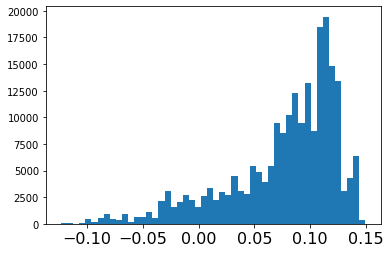

In [273]:
plt.hist(X_stndrd_train['scores'],bins=50)

### **Data Cleaning Removes Outliers**

>save the data in two different csv files

One for standards records and secound for outliers records

1.   standard_record-with-IsolationForest.csv
2.   outliers_record-with-IsolationForest.csv

In [254]:
standard_records = X_stndrd_train[X_stndrd_train.anomaly == 1]
standard_records.to_csv('standard_record-with-IsolationForest.csv')

In [255]:
outliers_records = X_stndrd_train[X_stndrd_train.anomaly == -1]
outliers_records.to_csv('outliers_record-with-IsolationForest.csv')

### **Principal Component Analysis (PCA)**

> Principal component analysis, or PCA, is a statistical procedure that allows you to summarize the information content in large data tables by means of a smaller set of “summary indices” that can be more easily visualized and analyzed.

Principal Component Analysis (PCA) is an unsupervised method for taking a data set where features have multi-collinearity and creating a decorrelated data set, by finding the linear combination of vectors which maximize the data's variances in orthogonal dimensions.



### Apply Principal Component Analysis (PCA) on standard_records files

In [256]:
# outliers_records

In [257]:
display(standard_records.head())
standard_records.shape

,Beneficiary gender code,Beneficiary Age category code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72,scores,anomaly
294047,-1.091073,-0.261926,1.358837,-0.527719,-1.525237,0.675882,-0.535666,-0.633326,-0.614540,0.605925,-0.577527,0.578783,0.693555,-0.557389,0.703414,0.797928,0.675738,-0.644045,0.566353,0.148099,-1.182672,-0.748407,-0.358409,0.594103,-0.940472,-0.645166,-1.124324,0.466025,-0.482817,-0.696127,-0.540720,1.069308,-0.579911,-0.043098,0.527300,-0.280999,-0.500179,-0.775557,-0.635931,-0.587259,-0.575537,0.930318,-0.514496,-0.473308,0.672521,-0.631232,0.628395,-0.575265,0.526249,-0.660972,1.132846,-0.714381,-0.896050,-0.580641,-0.444341,-0.560901,-0.694465,0.592570,-0.550693,0.647920,0.495333,0.508561,-0.758161,-0.375398,0.051640,-0.640513,0.570686,-0.406471,-0.635174,-0.974843,-0.287948,-0.565654,0.570353,-0.414594,0.494446,0.705150,-0.485459,-1.326829,0.816641,1.059602,1.440715,-0.942492,1.270715,-1.414089,-1.420024,-1.231286,-0.627732,-1.291947,-0.442551,1.340092,1.572721,-1.367128,1.206712,-2.010671,-1.273397,1.526070,1.108017,-1.380768,-1.887244,-1.337387,1.064121,-1.436058,1.319172,1.394062,-1.641446,1.603732,-2.188526,1.315220,-1.376738,-1.265251,0.517134,1.101675,0.691047,-1.358530,-1.173941,1.777612,1.466998,1.587501,-1.405722,1.359544,-1.250601,1.287714,-0.821076,1.350175,-1.396824,1.392002,1.245508,1.144821,0.416546,-1.738552,-1.088372,-0.044980,0.994982,1.858102,-1.220965,-0.625110,-1.405826,-1.289256,-1.333529,0.580007,1.046597,-1.136740,0.967680,0.213263,-0.059598,1.607363,-1.590423,1.209237,-1.852675,0.057515,1
368219,0.916529,-0.835733,-1.620225,-0.384233,0.589561,0.199483,-0.168422,-0.229076,-0.090881,0.133202,-0.368612,0.272071,0.258537,-0.236898,0.160514,0.460438,0.149715,-0.299319,0.144906,0.664147,0.128797,-0.151854,0.572529,0.166029,-0.033636,-0.156520,-0.905005,0.265492,0.875199,0.089461,-0.174723,0.146534,-0.169863,-0.860990,0.213118,-0.117192,-0.226817,0.096841,-0.231257,-0.165227,-0.106863,0.404594,-0.062053,-0.280083,0.173881,-0.170706,0.166846,-0.183299,0.132085,-0.099817,0.125712,-0.115872,-0.109619,-0.199918,-0.258015,-0.188321,-0.155029,0.177732,-0.224707,0.258340,0.045345,0.166493,-0.240576,-0.223723,-0.621387,-0.191979,0.246214,-0.202477,-0.173810,0.141917,0.155459,-0.184650,0.170343,-1.048893,0.327577,0.357797,-0.252399,1.108526,-1.035578,-0.864579,-1.209627,0.082073,-1.428996,1.351560,1.061568,0.642513,0.983459,0.500359,0.064612,-1.191554,-1.105701,1.070901,-1.061687,1.524817,1.103081,-1.112500,-0.919544,1.115966,0.493016,1.078205,-0.729964,1.126013,-1.057821,-1.060314,1.007333,-1.039033,0.965482,-1.016880,1.325918,-0.002912,-1.038177,-0.999742,-0.522428,1.084521,1.415224,-1.024763,-0.337938,-0.925723,1.046514,-0.950490,0.832491,-0.946300,1.226761,-1.033466,1.157704,-1.086724,-1.049117,-0.328049,-1.157254,1.081783,0.626758,0.6275

(196538, 151)

In [264]:
# drop the anomaly column
# standard_records = standard_records.drop('anomaly','scores', axis=1,inplace=True)
standard_records=standard_records.iloc[:,:149]
display(standard_records.head())
standard_records.shape

,Beneficiary gender code,Beneficiary Age category code,Inpatient days code,DRG quintile average payment amount,DRG quintile payment amount code,DRG_F1,DRG_F2,DRG_F3,DRG_F4,DRG_F5,DRG_F6,DRG_F7,DRG_F8,DRG_F9,DRG_F10,DRG_F11,DRG_F12,DRG_F13,DRG_F14,DRG_F15,DRG_F16,DRG_F17,DRG_F18,DRG_F19,DRG_F20,DRG_F21,DRG_F22,DRG_F23,DRG_F24,DRG_F25,DRG_F26,DRG_F27,DRG_F28,DRG_F29,DRG_F30,DRG_F31,DRG_F32,DRG_F33,DRG_F34,DRG_F35,DRG_F36,DRG_F37,DRG_F38,DRG_F39,DRG_F40,DRG_F41,DRG_F42,DRG_F43,DRG_F44,DRG_F45,DRG_F46,DRG_F47,DRG_F48,DRG_F49,DRG_F50,DRG_F51,DRG_F52,DRG_F53,DRG_F54,DRG_F55,DRG_F56,DRG_F57,DRG_F58,DRG_F59,DRG_F60,DRG_F61,DRG_F62,DRG_F63,DRG_F64,DRG_F65,DRG_F66,DRG_F67,DRG_F68,DRG_F69,DRG_F70,DRG_F71,DRG_F72,PRC_F1,PRC_F2,PRC_F3,PRC_F4,PRC_F5,PRC_F6,PRC_F7,PRC_F8,PRC_F9,PRC_F10,PRC_F11,PRC_F12,PRC_F13,PRC_F14,PRC_F15,PRC_F16,PRC_F17,PRC_F18,PRC_F19,PRC_F20,PRC_F21,PRC_F22,PRC_F23,PRC_F24,PRC_F25,PRC_F26,PRC_F27,PRC_F28,PRC_F29,PRC_F30,PRC_F31,PRC_F32,PRC_F33,PRC_F34,PRC_F35,PRC_F36,PRC_F37,PRC_F38,PRC_F39,PRC_F40,PRC_F41,PRC_F42,PRC_F43,PRC_F44,PRC_F45,PRC_F46,PRC_F47,PRC_F48,PRC_F49,PRC_F50,PRC_F51,PRC_F52,PRC_F53,PRC_F54,PRC_F55,PRC_F56,PRC_F57,PRC_F58,PRC_F59,PRC_F60,PRC_F61,PRC_F62,PRC_F63,PRC_F64,PRC_F65,PRC_F66,PRC_F67,PRC_F68,PRC_F69,PRC_F70,PRC_F71,PRC_F72
294047,-1.091073,-0.261926,1.358837,-0.527719,-1.525237,0.675882,-0.535666,-0.633326,-0.614540,0.605925,-0.577527,0.578783,0.693555,-0.557389,0.703414,0.797928,0.675738,-0.644045,0.566353,0.148099,-1.182672,-0.748407,-0.358409,0.594103,-0.940472,-0.645166,-1.124324,0.466025,-0.482817,-0.696127,-0.540720,1.069308,-0.579911,-0.043098,0.527300,-0.280999,-0.500179,-0.775557,-0.635931,-0.587259,-0.575537,0.930318,-0.514496,-0.473308,0.672521,-0.631232,0.628395,-0.575265,0.526249,-0.660972,1.132846,-0.714381,-0.896050,-0.580641,-0.444341,-0.560901,-0.694465,0.592570,-0.550693,0.647920,0.495333,0.508561,-0.758161,-0.375398,0.051640,-0.640513,0.570686,-0.406471,-0.635174,-0.974843,-0.287948,-0.565654,0.570353,-0.414594,0.494446,0.705150,-0.485459,-1.326829,0.816641,1.059602,1.440715,-0.942492,1.270715,-1.414089,-1.420024,-1.231286,-0.627732,-1.291947,-0.442551,1.340092,1.572721,-1.367128,1.206712,-2.010671,-1.273397,1.526070,1.108017,-1.380768,-1.887244,-1.337387,1.064121,-1.436058,1.319172,1.394062,-1.641446,1.603732,-2.188526,1.315220,-1.376738,-1.265251,0.517134,1.101675,0.691047,-1.358530,-1.173941,1.777612,1.466998,1.587501,-1.405722,1.359544,-1.250601,1.287714,-0.821076,1.350175,-1.396824,1.392002,1.245508,1.144821,0.416546,-1.738552,-1.088372,-0.044980,0.994982,1.858102,-1.220965,-0.625110,-1.405826,-1.289256,-1.333529,0.580007,1.046597,-1.136740,0.967680,0.213263,-0.059598,1.607363,-1.590423,1.209237,-1.852675
129866,-1.091073,-0.261926,1.358837,0.384160,1.294494,1.154116,-1.174393,-1.167671,-1.313115,1.223512,-1.132485,1.181440,1.259513,-1.212361,1.162822,1.117316,1.145514,-1.026868,1.110559,1.115850,-0.471254,-1.405372,-0.872142,1.178319,-1.306418,-1.141013,-0.273865,1.072452,0.949961,-1.275437,-1.208312,1.142330,-1.177446,0.275159,1.165275,-1.265457,-1.106978,-0.901122,-1.156486,-1.132624,-0.891331,1.094424,-1.165579,-1.191731,1.176971,-1.206899,1.143656,-1.120096,1.149915,-1.202967,1.206277,-1.220504,-1.267482,-1.161247,-1.101349,-1.150401,-1.178800,1.193161,-1.128431,1.193078,1.009965,1.182084,-1.303063,-0.853305,-1.174746,-1.211178,0.953618,-1.359870,-1.227260,-0.589470,-0.784217,-1.102858,1.164501,-1.073457,1.118969,1.155999,-1.104426,1.108526,-1.035578,-0.864579,-1.209627,0.082073,-1.428996,1.351560,1.061568,0.642513,0.983459,0.500359,0.064612,-1.191554,-1.105701,1.070901,-1.061687,1.524817,1.103081,-1.112500,-0.919544,1.115966,0.493016,1.078205,-0.729964,1.126013,-1.057821,-1.060314,1.007333,-1.039033,0.965482,-1.016880,1.325918,-0.002912,-1.038177,-0.999742,-0.522428,1.084521,1.415224,-1.024763,-0.337938,-0.925723,1.046514,-0.950490,0.832491,-0.946300,1.226761,-1.033466,1.157704,-1.086724,-1.049117,-0.328049,-1.157254,1.081783,0.626758,0.627584,-1.346256,-0.866511

(1311, 149)

In [275]:
# import pca 
from sklearn.decomposition import PCA

pca=PCA(copy=True, iterated_power='auto', n_components=2, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
X_reduce=pca.fit(standard_records)

In [276]:
x_pca=pca.transform(standard_records)

In [277]:
standard_records.shape

(1311, 149)

In [278]:
x_pca.shape

(1311, 2)

In [271]:
x_pca

array([[ -0.02878384,  12.13424997],
       [-10.72336846,  -3.6231559 ],
       [  1.75973327,  -7.95277622],
       ...,
       [ -9.53071707,  -3.5401258 ],
       [  0.59417476,  12.91422334],
       [ 10.41225213,   9.33286355]])